# Final Term - Amazon Reviews

## Datasets:
Original dataset: 
https://www.kaggle.com/adityapatil673/critical-assessment-amazon-reviews-on-kindle/data

In [1]:
# dependencies
import pandas as pd
import nltk
import numpy as np
import io
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from string import punctuation
from nltk import PorterStemmer
import copy 
import re, math
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
from nltk import bigrams
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.ldamodel import LdaModel
from gensim.models import Doc2Vec, Word2Vec
from gensim.corpora import Dictionary
import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/yuxu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuxu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/yuxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuxu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import data and generate data table with summary statistics

In [2]:
df = pd.read_csv('Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv')

In [3]:
df= df[df.name.str.contains("Kindle|kindle")==False]

In [4]:
df.name.value_counts()

Amazon Echo Show Alexa-enabled Bluetooth Speaker with 7" Screen                                     845
All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta            797
Amazon - Echo Plus w/ Built-In Hub - Silver                                                         590
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Blue Kid-Proof Case                              561
Fire Tablet, 7 Display, Wi-Fi, 16 GB - Includes Special Offers, Black                               371
Amazon Tap - Alexa-Enabled Portable Bluetooth Speaker                                               225
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                             217
Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Silver Aluminum         106
Fire Tablet with Alexa, 7" Display, 16 GB, Magenta - with Special Offers                            101
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 32 GB - Includes 

#### All Kindle products have been removed

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4089 entries, 96 to 4999
Data columns (total 24 columns):
id                     4089 non-null object
dateAdded              4089 non-null object
dateUpdated            4089 non-null object
name                   4089 non-null object
asins                  4089 non-null object
brand                  4089 non-null object
categories             4089 non-null object
primaryCategories      4089 non-null object
imageURLs              4089 non-null object
keys                   4089 non-null object
manufacturer           4089 non-null object
manufacturerNumber     4089 non-null object
reviews.date           4089 non-null object
reviews.dateAdded      991 non-null object
reviews.dateSeen       4089 non-null object
reviews.doRecommend    4089 non-null bool
reviews.id             24 non-null float64
reviews.numHelpful     4089 non-null int64
reviews.rating         4089 non-null int64
reviews.sourceURLs     4089 non-null object
reviews.text      

In [6]:
for col in df.columns:
    print(f'{col} : {df[col].nunique()}')

id : 16
dateAdded : 14
dateUpdated : 11
name : 15
asins : 16
brand : 1
categories : 15
primaryCategories : 3
imageURLs : 16
keys : 16
manufacturer : 1
manufacturerNumber : 16
reviews.date : 572
reviews.dateAdded : 377
reviews.dateSeen : 287
reviews.doRecommend : 2
reviews.id : 21
reviews.numHelpful : 22
reviews.rating : 5
reviews.sourceURLs : 2230
reviews.text : 3766
reviews.title : 2703
reviews.username : 3310
sourceURLs : 16


#### There are several columns not useful for the study

In [7]:
df.drop(['asins','reviews.id','dateUpdated','dateUpdated', 'primaryCategories', 'manufacturerNumber','reviews.dateAdded','reviews.id','brand','imageURLs','keys','reviews.sourceURLs','sourceURLs'], axis=1, inplace=True)

In [8]:
df['reviews.doRecommend'].value_counts()

True     3913
False     176
Name: reviews.doRecommend, dtype: int64

In [9]:
df['reviews.rating'].value_counts()

5    2855
4     991
3     152
2      46
1      45
Name: reviews.rating, dtype: int64

## Data is heavily skewed toward rating >3 and recommendation == True. Need to enrich with data that have lower rating or recommendation == False

In [10]:
df_large = pd.read_csv('1429_1.csv')

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
df_large = df_large[df_large.name.str.contains("Kindle|kindle")==False]

In [12]:
df_large.name.value_counts()

Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta                                                                                                                  10966
Echo (White),,,\r\nEcho (White),,,                                                                                                                                                       3309
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                                                                                  2814
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                                                                                   2527
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                                                                  1685
Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Spe

In [13]:
df_large['reviews.doRecommend'].value_counts()

True     21383
False     1019
Name: reviews.doRecommend, dtype: int64

In [14]:
df_large['reviews.rating'].value_counts()

5.0    14553
4.0     6206
3.0     1137
2.0      289
1.0      266
Name: reviews.rating, dtype: int64

In [15]:
# enrich original 5000 review data with large data that have recommendation == False or rating <=3
# low_rated_data = df_large[(df_large['reviews.rating']<=3) | (df_large['reviews.doRecommend'] == False)]

In [16]:
columns = ['id', 'name', 'categories', 'manufacturer', 'reviews.date',
       'reviews.dateSeen', 'reviews.doRecommend', 'reviews.numHelpful',
       'reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username']
df = pd.concat([df[columns], df_large[columns]],axis=0)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26560 entries, 96 to 27878
Data columns (total 12 columns):
id                     26560 non-null object
name                   26560 non-null object
categories             26560 non-null object
manufacturer           26560 non-null object
reviews.date           26543 non-null object
reviews.dateSeen       26560 non-null object
reviews.doRecommend    26491 non-null object
reviews.numHelpful     26516 non-null float64
reviews.rating         26540 non-null float64
reviews.text           26560 non-null object
reviews.title          26545 non-null object
reviews.username       26558 non-null object
dtypes: float64(2), object(10)
memory usage: 2.6+ MB


#### remove null values

In [18]:
df.dropna(subset=['reviews.doRecommend','reviews.rating','reviews.title','reviews.username'], how='any', inplace = True)

In [19]:
len(df)

26475

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26475 entries, 96 to 27878
Data columns (total 12 columns):
id                     26475 non-null object
name                   26475 non-null object
categories             26475 non-null object
manufacturer           26475 non-null object
reviews.date           26475 non-null object
reviews.dateSeen       26475 non-null object
reviews.doRecommend    26475 non-null object
reviews.numHelpful     26475 non-null float64
reviews.rating         26475 non-null float64
reviews.text           26475 non-null object
reviews.title          26475 non-null object
reviews.username       26475 non-null object
dtypes: float64(2), object(10)
memory usage: 2.6+ MB


In [21]:
df['reviews.doRecommend'].replace({False: 0, True:1}, inplace=True)

In [22]:
df['reviews.doRecommend'].value_counts()

1    25281
0     1194
Name: reviews.doRecommend, dtype: int64

In [23]:
df['reviews.rating'].value_counts()

5.0    17361
4.0     7188
3.0     1286
2.0      332
1.0      308
Name: reviews.rating, dtype: int64

In [ ]:
# convert rating >3 to 1 and rating <=3 to 0
# df.loc[df['reviews.rating']>3,'label'] = 1
# df.loc[df['reviews.rating']<=3,'label'] = 0

In [ ]:
# df.label.value_counts()

# Check whether review is biased to spam reviewers

In [24]:
user_reviews = df['reviews.username'].value_counts()
bulk_reviewers = user_reviews[user_reviews>=10]
print('% of reviewers with >=10 reviews: {:02f}%'.format(len(bulk_reviewers)*100/len(user_reviews)))
print('% of reviews posted by bulk reviewers: {:02f}%'.format(sum(bulk_reviewers)*100/sum(user_reviews)))

% of reviewers with >=10 reviews: 0.691327%
% of reviews posted by bulk reviewers: 9.174693%


count    2429.000000
mean        4.580897
std         0.718476
min         1.000000
25%         4.000000
50%         5.000000
75%         5.000000
max         5.000000
Name: reviews.rating, dtype: float64
count    24046.000000
mean         4.543791
std          0.751055
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews.rating, dtype: float64


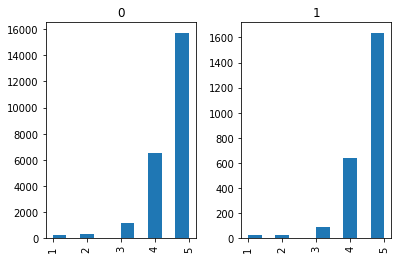

In [25]:
df['bulk']= df['reviews.username'].apply(lambda x : 1 if x in bulk_reviewers.index else 0)
#gives us the category whether a rating is bulk or not
from matplotlib import pyplot as plt
%matplotlib inline
print(df['reviews.rating'].hist(by=df.bulk))
print(df[df.bulk==1]['reviews.rating'].describe())
print(df[df.bulk==0]['reviews.rating'].describe())

## Not too much rating differences between bulk and single reviewers. Likely those bulk reviewers were just frequent shopper and vocal reviewers than spammers.

# Find the NPS net promoter score of amazon

*** Rating distribution ***
5.0    17361
4.0     7188
3.0     1286
2.0      332
1.0      308
Name: reviews.rating, dtype: int64


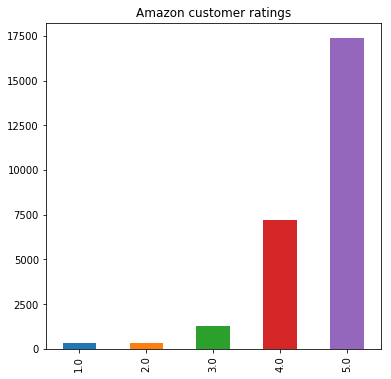

In [26]:
star = df['reviews.rating'].value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

Net Promoters Score helps us evaluate customer satisfaction and loyalty
Rating 1,2,3 - Detractors 
Rating 4 - Passive 
Rating 5 - Promoters 

NPS = (Promoters - Detractors)/Total ratings * 100

In [27]:
NPS_score = round (100*((star.loc[5])-sum(star.loc[1:3]))/sum(star.loc[:]),2)
print (" NPS score of Amazon is : "  + str(NPS_score))

 NPS score of Amazon is : 58.3


# Pick a product and deep dive

In [28]:
df.name.value_counts()

Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta                                                                                                                  10961
Echo (White),,,\r\nEcho (White),,,                                                                                                                                                       3299
All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi, 16 GB - Includes Special Offers, Magenta                                                                                                  2814
Amazon Fire Tv,,,\r\nAmazon Fire Tv,,,                                                                                                                                                   2526
Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16 GB, Green Kid-Proof Case                                                                                                                  1896
Amazon Echo Show Alexa-enabled Bluetooth Speaker w

In [31]:
tablet=df[df.name=='Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta']

 NPS score of Tablet is : 49.79


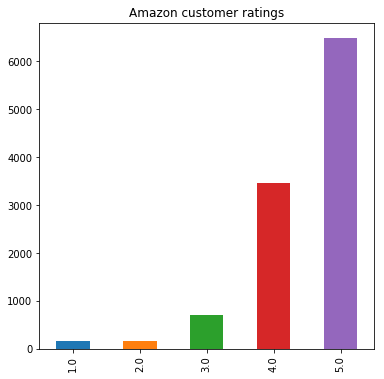

In [34]:
tablet_s = tablet['reviews.rating'].value_counts()
tablet_s.sort_index(inplace=True)

Tablet_NPS_score = round (100*(tablet_s[5]-sum(tablet_s[1:3]))/sum(tablet_s),2)
print (" NPS score of Tablet is : "  + str(Tablet_NPS_score))
#better NPS than overall amazon
tablet_s.plot(kind='bar',title='Amazon customer ratings',figsize=(6,6),style='Solarize_Light2')

In [35]:
tablet['reviews.doRecommend'].value_counts()

1    25281
0     1194
Name: reviews.doRecommend, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a156592e8>,
      dtype=object)

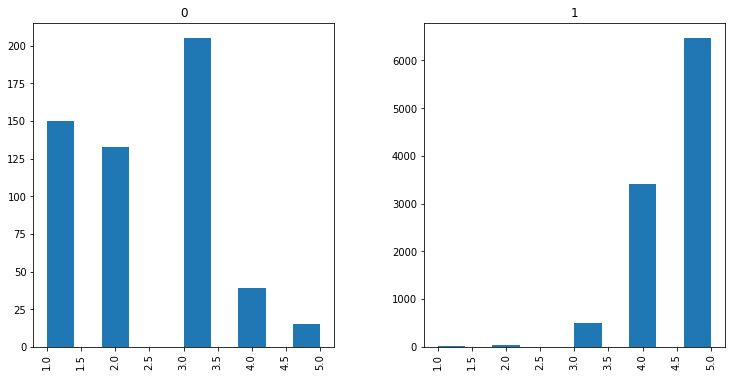

In [36]:
tablet['reviews.rating'].hist(by=tablet['reviews.doRecommend'],figsize=(12,6))

In [38]:
plus_tablet = tablet[tablet['reviews.doRecommend']==1]['reviews.rating'].value_counts()
plus_tablet.sort_index(inplace=True)
recomm_NPS = round(100*(sum(plus_tablet[4:5])-sum(plus_tablet[1:2]))/sum(plus_tablet),2)
minus_tablet = tablet[tablet['reviews.doRecommend']==0]['reviews.rating'].value_counts()
minus_tablet.sort_index(inplace=True)
notrecomm_NPS = round(100*(sum(minus_tablet[4:5])-sum(minus_tablet[1:2]))/sum(minus_tablet),2)
print("Those who recommend amazon tablet generate high NPS score of " + str(recomm_NPS))
print("Those who DO NOT recommend tablet produce a NPS score of " + str(notrecomm_NPS))
print(" ~ pretty much correct definition of NPS score")

Those who recommend amazon tablet generate high NPS score of 94.44
Those who DO NOT recommend tablet produce a NPS score of -42.25
 ~ pretty much correct definition of NPS score


### it seems that Fire Tablet NPC is lower than average. People are less satisfied with Fire Tablet

# [Fire Tablet] - Plot time series for reviews

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


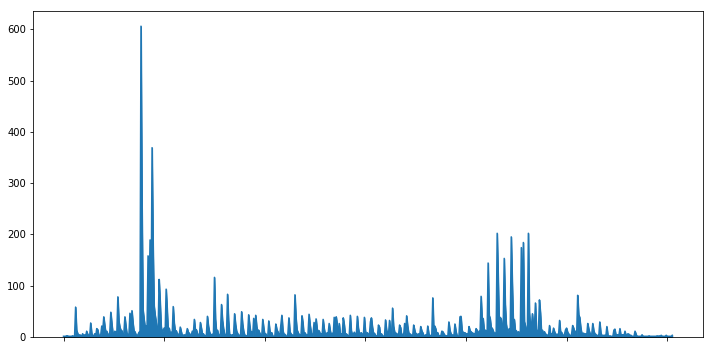

In [39]:
tablet['temp'] = tablet['reviews.date'].apply(lambda x : pd.to_datetime(x))
tablet_review_dates = tablet['reviews.date'].value_counts()
tablet_review_dates.sort_index(inplace=True)
tablet_review_dates.plot(kind='area',figsize=(12,6))

In [40]:
rating_perdate = tablet_review_dates.sort_values(ascending=False)
peakrating = rating_perdate[:20]
peak_month=[]
for x in peakrating.index:
    peak_month.append(pd.to_datetime(x).month)
pd.Series(peak_month).value_counts()

1     11
12     6
3      2
6      1
dtype: int64

### Results
January has the highest number of peaks >> Activity is high >> More Sales during Jan ( Holiday season)

December has the 2nd highest number of peaks >> Activity is high >> Good Sales during Dec ( Holiday season)

There is high degree of variance in reviews added over time

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1b8c4668>]],
      dtype=object)

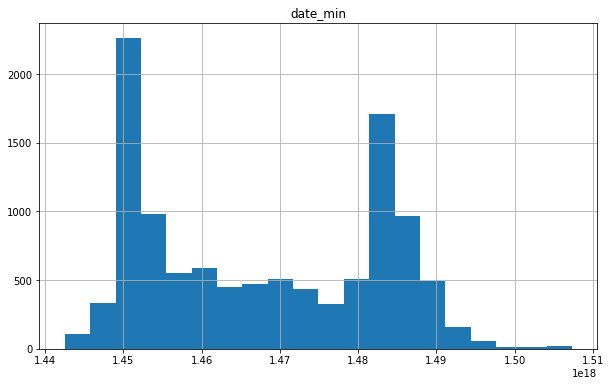

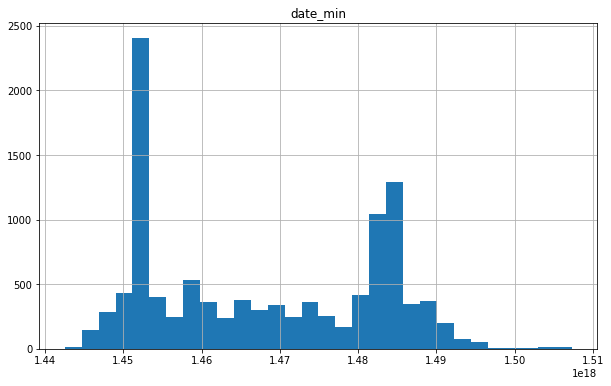

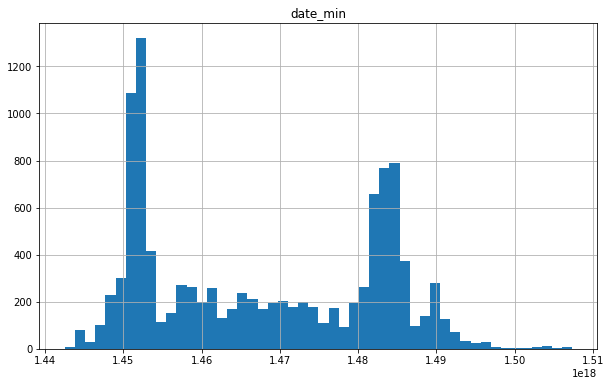

In [42]:
rating_series = pd.DataFrame(tablet['reviews.date'])
dforms=[]
for x in rating_series['reviews.date']:
    dforms.append((pd.to_datetime(x)).value)
# now we have dforms which has dates transformed to numeric values
rating2 = rating_series.assign(date_min = dforms)
rating2.reset_index(inplace=True)
#rating2.set_index('date_min')
#rating2.columns=['timestamp_string','review_count','date_min']
bins = np.linspace(min(rating2.date_min),max(rating2.date_min),num=50)
rating2.hist(column='date_min', bins=20,figsize=(10,6),)
rating2.hist(column='date_min', bins=30,figsize=(10,6))
rating2.hist(column='date_min', bins=50,figsize=(10,6))

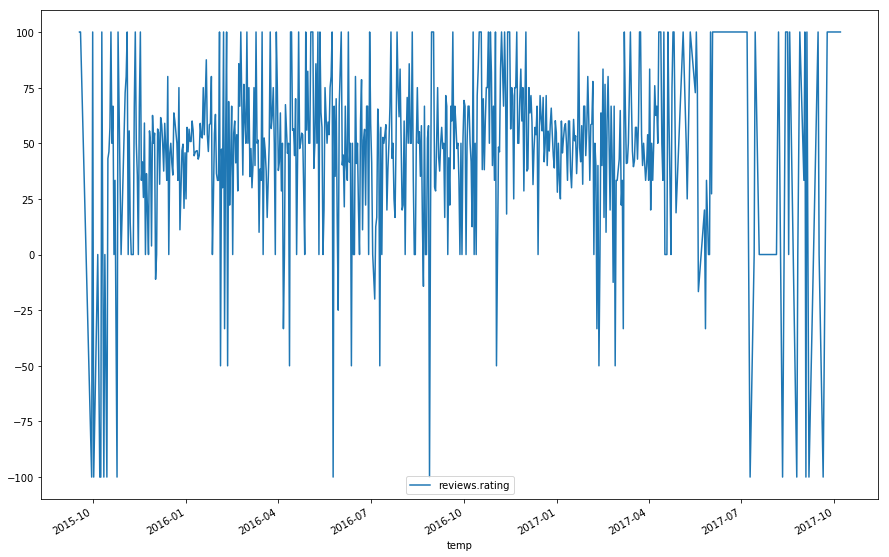

In [43]:
def NPS_eval (A):
    score =0
    for x in A[:]:
        if (x>4) :
            score+=1
        elif (x<4) :
            score-=1
    return 100*score/len(A)

NPS_overtime = tablet[['temp','reviews.rating']]
NPS_overtime.groupby(by='temp').agg(NPS_eval).plot(figsize=(15,10))

AxesSubplot(0.125,0.125;0.775x0.755)


/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,reviews.rating
timeline,
31,25.000000
9,33.333333
32,33.333333
33,35.714286
10,37.500000
29,39.130435
11,41.509434
20,43.636364
14,44.881890


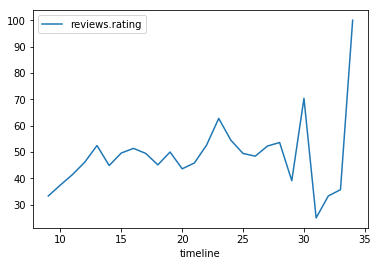

In [44]:
NPS_overtime['timeline']= NPS_overtime['temp'].apply(lambda x : (x.month+(12*(x.year-2015))))
NPS_by_month= NPS_overtime.groupby(by='timeline').agg(NPS_eval)
print(NPS_by_month.plot())
NPS_by_month.sort_values(by='reviews.rating')

# [Fire Tablet] Predict Recommendations based on reviews content

In [45]:
tablet.head()

,id,name,categories,manufacturer,reviews.date,reviews.dateSeen,reviews.doRecommend,reviews.numHelpful,reviews.rating,reviews.text,reviews.title,reviews.username,bulk,temp
3480,AVqVGZNvQMlgsOJE6eUY,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Electronics,iPad & Tablets,All Tablets,Compute...",Amazon,2017-10-07T00:00:00.000Z,2017-10-10T00:00:00Z,1,0.0,5.0,The sales people are really nice and knowledge...,Great product,richard,0,2017-10-07
3481,AVqVGZNvQMlgsOJE6eUY,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Electronics,iPad & Tablets,All Tablets,Compute...",Amazon,2017-10-07T00:00:00.000Z,2017-10-10T00:00:00Z,1,0.0,5.0,Great product and service and the sales man r ...,Great product,richard,0,2017-10-07
3482,AVqVGZNvQMlgsOJE6eUY,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Electronics,iPad & Tablets,All Tablets,Compute...",Amazon,2017-10-07T00:00:00.000Z,2017-10-10T00:00:00Z,1,0.0,5.0,Great product and service will refer to a frie...,Great product and service,richard,0,2017-10-07
3483,AVqVGZNvQMlgsOJE6eUY,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Electronics,iPad & Tablets,All Tablets,Compute...",Amazon,2017-10-06T00:00:00.000Z,2017-10-10T00:00:00Z,1,0.0,5.0,very good product and service will refer a fri...,very good product and service.,Richard,1,2017-10-06
3484,AVqVGZNvQMlgsOJE6eUY,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Electronics,iPad & Tablets,All Tablets,Compute...",Amazon,2017-09-30T00:00:00.000Z,2017-10-10T00:00:00Z,1,0.0,5.0,Great selections. Hard to find assistance at t...,Good selection.,Scheu,0,2017-09-30


In [47]:
tablet.rename(columns={'reviews.rating':'rating',
                       'reviews.date':'date',
                       'reviews.dateSeen':'dateSeen',
                       'reviews.doRecommend':'doRecommend',
                       'reviews.numHelpful':'numHelpful',
                       'reviews.text':'text',
                       'reviews.title':'title',
                       'reviews.username':'username'
                      }, 
                 inplace=True)

/anaconda3/envs/nlp_venv/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [50]:
comments = pd.concat([tablet['text']+". "+ tablet['title'],tablet['rating'],tablet['doRecommend']],axis=1)
comments.columns=['text','rating','recommend']

In [54]:
stopwords = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()


def clean_stem (sent): 
    temp1 ="".join(x for x in sent if x not in punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3

def clean_lemma (sent): 
    temp1 ="".join(x for x in sent if x not in punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectstem = TfidfVectorizer(analyzer=clean_stem)
vectlemm = TfidfVectorizer(analyzer=clean_lemma)

textfeatures=vectstem.fit_transform(comments['text'])
print("Stemmed - " + str(len(vectstem.get_feature_names())))

vectlemm.fit_transform(comments['text'])
print("Lemmatized - " + str(len(vectlemm.get_feature_names())))

Stemmed - 6511
Lemmatized - 7923


In [59]:
# have a look at our stemmed data
textmatrix = pd.DataFrame(textfeatures.toarray(),columns=vectstem.vocabulary_).head(15)
textmatrix

,sale,peopl,realli,nice,knowledg,come,back,great,product,servic,...,paw,on,rad,strang,naviag,fore,windowsbas,lockeddown,outclass,facial
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
sum_scores = pd.DataFrame(textmatrix.sum(),columns=['sum_scores_TFIDF'])
sum_scores.head(10)

,sum_scores_TFIDF
sale,0.000000
peopl,0.000000
realli,0.000000
nice,0.000000
knowledg,0.000000
come,0.000000
back,0.427813
great,0.000000
product,0.000000
servic,0.000000


In [62]:
# Need to see most important words in the reviews
# high usage of words in reviews
sum_scores.sort_values(by='sum_scores_TFIDF',ascending=False)[:5] 

,sum_scores_TFIDF
underpow,1.832239
slate,1.574400
alreadygood,1.459379
25000,1.388765
forgood,1.133246


In [63]:
pd.set_option('display.max_colwidth', 0)
comments.head()

,text,rating,recommend
3480,The sales people are really nice and knowledgeable to me I will come back again. Great product,5.0,1
3481,Great product and service and the sales man r really nice.. Great product,5.0,1
3482,Great product and service will refer to a friend. And the sales man r good. Great product and service,5.0,1
3483,very good product and service will refer a friend.. very good product and service.,5.0,1
3484,Great selections. Hard to find assistance at times.. Good selection.,5.0,1


# Sentiment analysis

In [65]:
sid = SentimentIntensityAnalyzer()
# Feature 1 : Sentiment compound value
def sentiment(x):
    score = sid.polarity_scores(x)
    return score['compound']
    
#sentiment(happy)
comments['sentiment']= comments['text'].apply(lambda x : sentiment(x))

In [66]:
# Feature 2 : Length of string

comments['length'] = comments['text'].apply(lambda x : len(re.split('\W+',x)))
comments[comments['rating']==5].head(10)

,text,rating,recommend,sentiment,length
3480,The sales people are really nice and knowledgeable to me I will come back again. Great product,5.0,1,0.8016,17
3481,Great product and service and the sales man r really nice.. Great product,5.0,1,0.8481,13
3482,Great product and service will refer to a friend. And the sales man r good. Great product and service,5.0,1,0.9360,19
3483,very good product and service will refer a friend.. very good product and service.,5.0,1,0.7496,15
3484,Great selections. Hard to find assistance at times.. Good selection.,5.0,1,0.7650,11
3485,This kindle is a basic and easy to use eReader. Exactly what I wanted. The charge lasts for a long time so you don't have to worry about charging it daily.. Exactly what I wanted,5.0,1,0.6492,36
3488,Very good reading on this good and strong quality kindle. Great kindle.,5.0,1,0.9298,13
3490,I particularly like the fact that the text shows up and you can see it well outside on a sunny day. I use it with Kindle Unlimited.. Love it!,5.0,1,0.9039,30
3492,I purchased this product because I love to read and buying books got costly. With this product I can read all I want for 10.00 a month. Love to read,5.0,1,0.8519,31
3494,Excellent product very good piece strongly recommend. Great kindle,5.0,1,0.9419,9


In [67]:
comments[comments['rating']==1].head(5)

,text,rating,recommend,sentiment,length
3544,Am used to Kindle Fire which I love. No light to read by in the dark. Hard to navigate. This was a gift - would never purchase on my own.. HATE IT!!!!!,1.0,0,-0.5425,32
3824,This device is OK for reading or listening to audiobooks via Overdrive app. Wouldn't recommend it though really. Waited to buy Kindle for years. Would suggest doing research before buying this device.. Extremely slow,1.0,0,0.2079,35
3853,Not Kid friendly at all. Purchased for little nephew. Wasn't given any info on it for sales person either. Took back!!!. Terrible,1.0,0,-0.7652,23
3855,Screen was cracked but the package did arrive earlier than expected. Arrived broken,1.0,0,-0.6310,13
3900,Purchased two of these tablets. Both of them had 4-7 dead pixels all over the screen. Read a lot of online reviews which stated same problem. The screen/resolution is pretty bad but what can you expect for $50.. Ok tablet I must have got 2 bad ones,1.0,0,-0.7650,49


### Get raw sentiment score magnifier from counting exlamation marks and full cap words

In [85]:
def get_cap_and_exclamation_score(line):
    # 1+ len is to make sure the value is at least 1, for later use to multiply with other factors.
    return 1+len(re.findall(r'!{2,}', line)) + len(re.findall(r'[A-Z]{2,}', line))

comments['strong_sentiment'] = comments['text'].apply(get_cap_and_exclamation_score)

In [87]:
def tokenize(text):
    min_length = 3
    # tokenize
    # convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stop words and punctuation
    words = [word for word in words if word not in cachedStopWords]
    # steming
    tokens = list(map(lambda token: PorterStemmer().stem(token), words))
    # lemmatize
    lemmas = [WordNetLemmatizer().lemmatize(word) for word in tokens]
    # only focus on alphabetic words
    p = re.compile('[a-zA-Z]+')
    
    filtered_lemmas = list(filter(lambda lemma: p.match(lemma) and len(lemma) >= min_length, lemmas))
    return filtered_lemmas

In [88]:
comments['text_clean']=comments['text'].astype('U').apply(tokenize)

In [93]:
comments.head()

,text,rating,recommend,sentiment,length,strong_sentiment,text_clean,topics
3480,The sales people are really nice and knowledgeable to me I will come back again. Great product,5.0,1,0.8016,17,1,"[sale, peopl, realli, nice, knowledg, come, back, great, product]","[nice, peopl, realli]"
3481,Great product and service and the sales man r really nice.. Great product,5.0,1,0.8481,13,1,"[great, product, servic, sale, man, realli, nice.., great, product]","[great, product, man]"
3482,Great product and service will refer to a friend. And the sales man r good. Great product and service,5.0,1,0.9360,19,1,"[great, product, servic, refer, friend, sale, man, good, great, product, servic]","[great, product, servic]"
3483,very good product and service will refer a friend.. very good product and service.,5.0,1,0.7496,15,1,"[good, product, servic, refer, friend.., good, product, servic]","[product, good, servic]"
3484,Great selections. Hard to find assistance at times.. Good selection.,5.0,1,0.7650,11,1,"[great, select, hard, find, assist, times.., good, select]","[select, assist]"


### Use LDA to explore topics as a feature

In [90]:
dictionary = Dictionary(comments['text_clean'])

In [91]:
def get_topics_(tokenized_words):
    new_doc_bow = [dictionary.doc2bow(tokenized_words)]
    model_ = LdaModel(new_doc_bow, num_topics=1, id2word=dictionary, passes=5)
    return [topic.replace('"','') for topic in re.findall(r'"\w+"', list(*model_.print_topics(num_words=3))[1])]

In [92]:
comments['topics']=comments['text_clean'].apply(get_topics_)

In [95]:
tfidf_v = TfidfVectorizer()
topicfeatures=tfidf_v.fit_transform(comments['topics'].apply(lambda x: ' '.join(x)))

# apply compound ranking

In [97]:
comments['compound_score'] = 5*comments['sentiment']+2*comments['length']+10*comments['strong_sentiment']

# fit data with random forest model

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

# need to reset index of the comments column to match with textfeatures
new_sentiment = comments.sentiment.reset_index()['sentiment']
new_length = comments.length.reset_index()['length']
compound_score = comments.compound_score.reset_index()['compound_score']
strong_sentiment = comments['strong_sentiment'].reset_index()['strong_sentiment']

x_features = pd.concat([new_sentiment,
                        new_length,
                        compound_score,
                        pd.DataFrame(topicfeatures.toarray(),
                        columns=tfidf_v.vocabulary_),
                        pd.DataFrame(textfeatures.toarray(),
                        columns=vectstem.vocabulary_)],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_features,comments.recommend,test_size=0.2)

rf = RandomForestClassifier(n_jobs=-1,n_estimators=50,max_depth=90)
rfmodel=rf.fit(x_train,y_train)

y_pred = rfmodel.predict(x_test)
sorted(zip(rfmodel.feature_importances_,x_train.columns),reverse=True)[0:10]

[(0.055525465664453606, 'sentiment'),
 (0.015858811309332903, 'one1'),
 (0.014776007868285307, 'toilet'),
 (0.013047306155094442, 'onei'),
 (0.012775289607416623, 'minu'),
 (0.011485563480497674, 'compound_score'),
 (0.010780946836450565, 'length'),
 (0.007132768045316964, 'youtubepandora'),
 (0.00651520350930046, 'preload'),
 (0.005778959784987658, 'lay')]

In [100]:
precision, recall, fscore , support = score(y_test,y_pred,average='binary')
print('Precision: {} / Recall :{} / Accuracy {} '.format(round(precision,3),
                                                         round(recall,3),
                                                         round((y_pred==y_test).sum()/len(y_test),3)))

Precision: 0.948 / Recall :0.999 / Accuracy 0.948 


# Using features such as sentiment compound value and length of reviews, a random forest model fits and predict very well to the test set, with Precision: 0.948 / Recall :0.999 / Accuracy 0.948